In [1]:
#including packages and modules that will be needed 
import itertools
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt, warnings
import seaborn as sns
from collections import Counter

from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randuni


from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import ElasticNet, ElasticNetCV, SGDRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from imblearn.pipeline import make_pipeline

#sns.set_style('white')
%matplotlib inline

RANDOM_STATE = 101

In [2]:
hyper_param_grid = {'LR':{"l1_ratio": sp_randuni(0.01, 1),
                    "alpha": np.logspace(-2, 5, 100)
                     }
             }

In [3]:
def build_response_model(X,y,hyper_param_grid,cvFolds = 10,
                         randomIterations=10,scoring='r2',
                         isFitIntercept=True,isNormalize=True,
                         isCopyX=True,maxIterations=5000,randomState=101):
    
    np.random.seed(randomState)
    model = RandomizedSearchCV(estimator=ElasticNet(fit_intercept=isFitIntercept,
                                                    normalize=isNormalize,
                                                    copy_X=isCopyX,
                                                    random_state=randomState,
                                                    max_iter=maxIterations),
                               param_distributions=hyper_param_grid["LR"],
                               n_iter=randomIterations,
                               cv=cvFolds,
                               scoring=scoring)
    model.fit(X,y)
    
    return (model.best_score_,model.best_estimator_.coef_)


def get_indices_topK_biomarkers(modelWeights, topK=10):
    posIndices = np.argpartition(modelWeights, -topK)[-topK:]
    posIndices = posIndices[np.argsort(-modelWeights[posIndices])]
    
    negIndices = np.argpartition(modelWeights, topK)[:topK]
    negIndices = negIndices[np.argsort(modelWeights[negIndices])]
    
    return posIndices, negIndices


def get_biomarker_topK_patients(X,y,patientIDs,biomarkerIDs,topK,posIndices,negIndices):
    
    sampleSum=np.sum(X[:,posIndices],1)
    posIndicesPatients=(-sampleSum).argsort()[:topK]
    
    sampleSum=np.sum(X[:,negIndices],1)
    negIndicesPatients=(sampleSum).argsort()[-topK:]
    
    biomarkerIDs = np.array(biomarkerIDs)[np.concatenate((posIndices,negIndices))]
    
    patientBiomarkers = X[:,np.concatenate((posIndices,negIndices))]

    patientIDs = np.array(patientIDs)[np.concatenate((posIndicesPatients,negIndicesPatients))]
    
    patientBiomarkers = patientBiomarkers[np.concatenate((posIndicesPatients,negIndicesPatients)),:]
    
    patientDrugResponses = y[np.concatenate((posIndicesPatients,negIndicesPatients))]
    
    return patientIDs, biomarkerIDs, patientBiomarkers, patientDrugResponses

def plot_biomarkers(patientBiomarkers,patientDrugResponses,patientIDs,biomarkerIDs,selectedDrug):
    patientBiomarkers_df = pd.DataFrame(patientBiomarkers)
    patientDrugResponses_df = pd.DataFrame(patientDrugResponses)
    patientBiomarkers_df.index = patientIDs
    patientBiomarkers_df.columns = biomarkerIDs

    patientDrugResponses_df.index = patientIDs
    patientDrugResponses_df.columns = ["DrugID:" + selectedDrug]
    
    patientBiomarkers_df=(patientBiomarkers_df-patientBiomarkers_df.mean(axis=0))/patientBiomarkers_df.std(axis=0)

    patientDrugResponses_df=(patientDrugResponses_df-patientDrugResponses_df.mean(axis=0))/patientDrugResponses_df.std(axis=0)

    patientBiomarkers_df = pd.concat([patientBiomarkers_df,patientDrugResponses_df],axis=1)
    
    plt.figure(figsize=(25,10))
    sns.heatmap(patientBiomarkers_df.T,cmap='coolwarm',annot_kws={"size": 24})
    #ax.figure.axes[-1].yaxis.label.set_size(20)
    plt.show()


In [4]:
geneExpression = pd.read_csv('data/gdsc_gene_expression.csv',index_col=0)
drugResponse = pd.read_csv('data/gdsc_drug_response.csv',index_col=0)

In [5]:
drugIDs = drugResponse.columns.tolist()
#print(drugIDs)
#['AP-24534', 'Nilotinib', 'Imatinib', 'Dasatinib', 'AKT-inhibitor-VIII', 
#'A-443654', 'NVP-TAE684', 'V-680', 'TW-37', 'Obatoclax-Mesylate', 'ABT-263', 
#'GNF-2', 'AZ628', 'PL4720', 'SB590885', 'RO-3306', 'CGP-60474', 'CGP-082996', 
#'PD-0332991', 'Roscovitine', 'Erlotinib', 'Gefitinib', 'Lapatinib', 'BIBW2992', 
#'PD-173074', 'RDEA119', 'CI-1040', 'PD-0325901', 'AZD6244', 'PF-02341066', 
#'Rapamycin', 'JW-7-52-1', 'Temsirolimus', 'Axitinib', 'Sunitinib', 'Sorafenib', 
#'GDC0941', 'TG221', 'AZD6482', 'GW843682', 'BI-2536', 'A-770041', 'WH-4-023', 
#'Bosutinib', 'AZD-0530', 'Pazopanib', 'AMG-706']
patientIDs = drugResponse.index.tolist()
#patientIDs

biomarkerIDs = geneExpression.columns.tolist()
#biomarkerIDs

In [6]:
X=np.array(geneExpression)
Y=np.array(drugResponse)

In [7]:
selectedDrug = 'Lapatinib'  #'Erlotinib', 'Gefitinib', 'Lapatinib'
drugIndex = drugIDs.index(selectedDrug)

In [8]:
performance, modelWeights = build_response_model(X,Y[:,drugIndex],hyper_param_grid,randomIterations=20)

In [9]:
posIndices, negIndices = get_indices_topK_biomarkers(modelWeights,10)

In [10]:
patientIDs, biomarkerIDs, patientBiomarkers, patientDrugResponses = get_biomarker_topK_patients(X,Y[:,drugIndex],patientIDs,biomarkerIDs,20,
                                                                                                posIndices,negIndices)

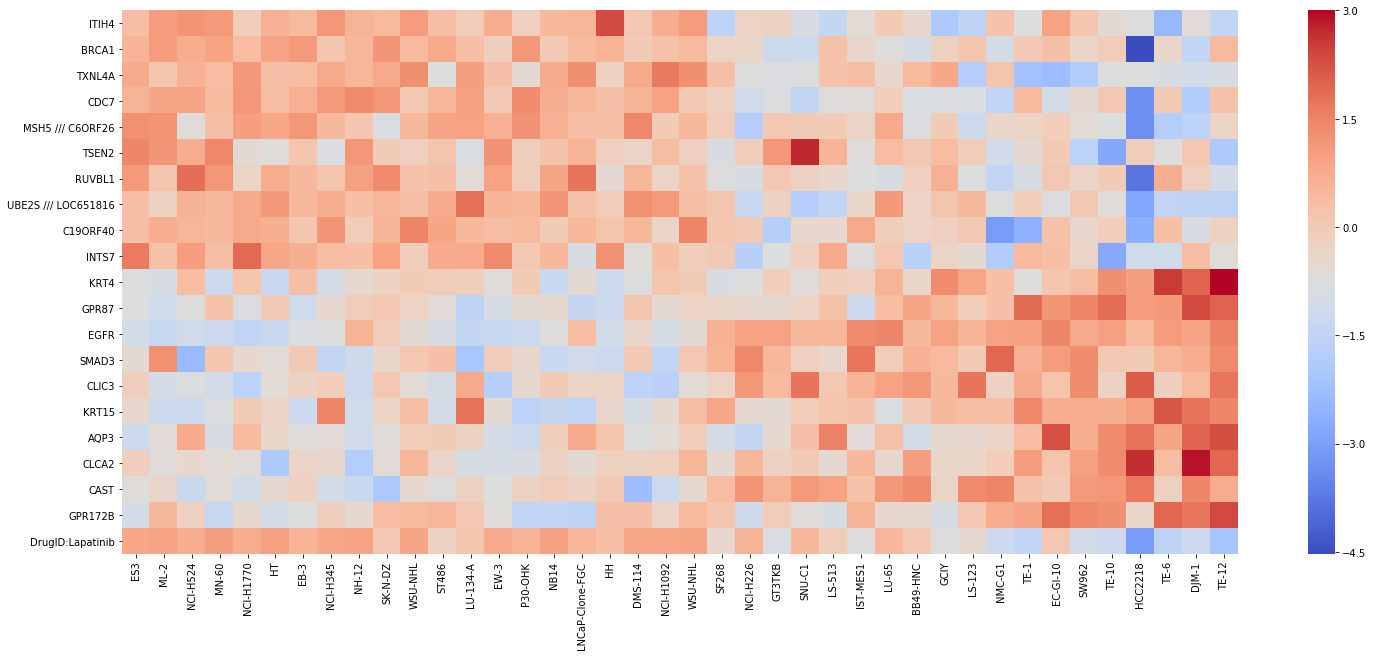

In [11]:
plot_biomarkers(patientBiomarkers,patientDrugResponses,patientIDs,biomarkerIDs,selectedDrug)